In [427]:
import re

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import matplotlib.pyplot as plt

In [428]:
# df = pd.read_csv("https://raw.githubusercontent.com/amitness/gender-data/refs/heads/master/genders.csv")
df = pd.read_csv("names.csv")
df = pd.DataFrame(df)
# df["name"] = df["name"].apply(lambda x: re.sub(r"\(.*?\)", "", x))
names = df.name.unique()

Distribution of names based on the first letter

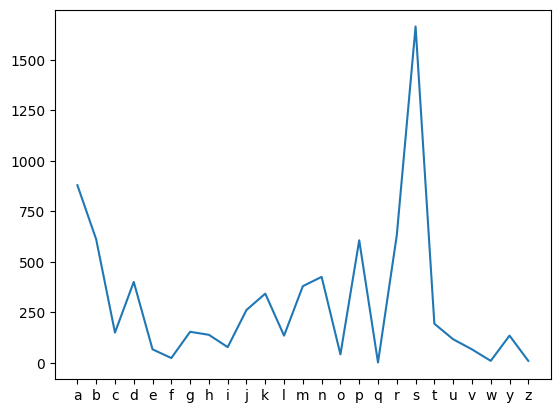

In [429]:
count = {}
for nm in names:
  if nm[0] in count:
    count[nm[0]] += 1
  else:
    count[nm[0]] = 1

plt.plot(count.keys(), count.values())

Getting all the vowels out of data and making a key value map of:
  - character to index
  - index to character

In [430]:
vowels = ["."] + sorted(list(set("".join(names))))
char_to_ix = {
    ch: i for i, ch in enumerate(vowels)
}
ix_to_char = {
    i: ch for i, ch in enumerate(vowels)
}

### Sample of what the data if indexed to vowels looks like

In [431]:
block_size = 3
for nm in names[:2]:
  block = ["."] * block_size
  nm = nm + "."
  print(nm)
  for ch in nm:
    print(block, ch)
    block = block[1:] + [ch]

aabha.
['.', '.', '.'] a
['.', '.', 'a'] a
['.', 'a', 'a'] b
['a', 'a', 'b'] h
['a', 'b', 'h'] a
['b', 'h', 'a'] .
aabhas.
['.', '.', '.'] a
['.', '.', 'a'] a
['.', 'a', 'a'] b
['a', 'a', 'b'] h
['a', 'b', 'h'] a
['b', 'h', 'a'] s
['h', 'a', 's'] .


### Code to generate training and testing data

In [432]:
device = "cpu"
if torch.cuda.is_available():
  device = torch.device("cuda")

print(device)

cuda


In [433]:
def generate_data(data, block_size):
  X = []
  Y = []
  for d in data:
    block = [0] * block_size
    d = d + "." # to indicate the end of a nmae
    for ch in d:
      X.append(block)
      Y.append(char_to_ix[ch])
      block = block[1:] + [char_to_ix[ch]]
  # X, Y = torch.tensor(X), torch.tensor(Y)
  X, Y = torch.tensor(X).to(device=device), torch.tensor(Y).to(device=device)
  return X, Y

In [434]:
total_names = len(names)
num_train, num_test = round(0.8 * total_names), round(0.2 * total_names)

block_size = 3

X_train, Y_train = generate_data(names[:num_train], block_size)
X_test, Y_test = generate_data(names[num_train:], block_size)

X_train[:2]

tensor([[0, 0, 0],
        [0, 0, 1]], device='cuda:0')

In [435]:
V = len(vowels); D = 10; batch_size = 500; hidden_size = 100
lr = 0.05

char_embeddings = torch.randn(V, D).to(device=device)

char_embeddings[X_train].shape

torch.Size([44957, 3, 10])

In [436]:
def flatten(x):
  N = x.shape[0]
  return x.view(N, -1)

idxs = torch.randint(0, V, size=(batch_size,))
emb = nn.Embedding(num_embeddings=V, embedding_dim=D)
fc1 = nn.Linear(D * block_size, 100) # embedding_dim * block size
bn = nn.BatchNorm1d(100)
fc2 = nn.Linear(100, V) # hidden_size, num_classes

x = emb(X_train[idxs].to(device="cpu"))
print(x.shape)

x = flatten(x)
print(x.shape)

x = fc1(x)
print(x.shape)

x = bn(x)
print(x.shape)

x = F.tanh(x)
print(x.shape)

x = fc2(x)
print(x.shape)


del x, emb, fc1, fc2, bn;

torch.Size([500, 3, 10])
torch.Size([500, 30])
torch.Size([500, 100])
torch.Size([500, 100])
torch.Size([500, 100])
torch.Size([500, 27])


In [437]:
class NameGenModel(nn.Module):
  def __init__(self, hidden_size, block_size, embedding_dim, num_classes):
    super().__init__()
    self.embed = nn.Embedding(num_embeddings=num_classes, embedding_dim=embedding_dim)

    self.fc1 = nn.Linear(embedding_dim * block_size, hidden_size)
    nn.init.xavier_normal_(self.fc1.weight)

    self.bn = nn.BatchNorm1d(hidden_size)

    self.fc2 = nn.Linear(hidden_size, num_classes)
    nn.init.xavier_normal_(self.fc2.weight)
  
  def forward(self, x):
    x = self.embed(x) # becomes (N, block_size, embedding_dim)
    x = flatten(x) # becomes: (N, block_size * embedding_dim)
    x = self.fc1(x)
    x = self.bn(x)
    x = F.tanh(x)
    scores = self.fc2(x)
    
    return scores


In [438]:
model = NameGenModel(hidden_size, block_size, D, V)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [439]:
def check_accuracy(model: NameGenModel, x: torch.tensor, y: torch.tensor):
  num_correct = 0
  num_samples = 0
  model.eval()

  with torch.no_grad():
    x = x.to(device=device, dtype=torch.long)
    y = y.to(device=device, dtype=torch.long)
    scores = model(x)

    _, preds = scores.max(axis=1)
    num_correct = (preds == y).sum()
    num_samples = preds.size(0)
  
  acc = float(num_correct) / num_samples

  print(f"got {100 * acc} % correct")
      

In [440]:
epochs = 1
model = model.to(device=device)

loss_history = []

for e in range(epochs):
  print(f"Epoch {e}:")
  for t in range(4000):
    model.train()
    idxs = torch.randint(0, X_train.shape[0], size=(batch_size,))
    x, y = X_train[idxs], Y_train[idxs]
    # copying tensors to gpu (if available)
    # x, y = x.to(device=device, dtype=torch.long), y.to(device=device, dtype=torch.long)

    scores = model(x)

    loss = F.cross_entropy(scores, y)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    loss_history.append(loss.item())
    if t % 500 == 0:
      print(f"\tIteration {t}, loss = {loss.item()}")
  # check_accuracy(model, X_test, Y_test)


Epoch 0:
	Iteration 0, loss = 3.617967128753662
	Iteration 500, loss = 2.198820114135742
	Iteration 1000, loss = 2.1835644245147705
	Iteration 1500, loss = 2.1057403087615967
	Iteration 2000, loss = 2.069617986679077
	Iteration 2500, loss = 2.075352668762207
	Iteration 3000, loss = 2.105412483215332
	Iteration 3500, loss = 2.0019521713256836


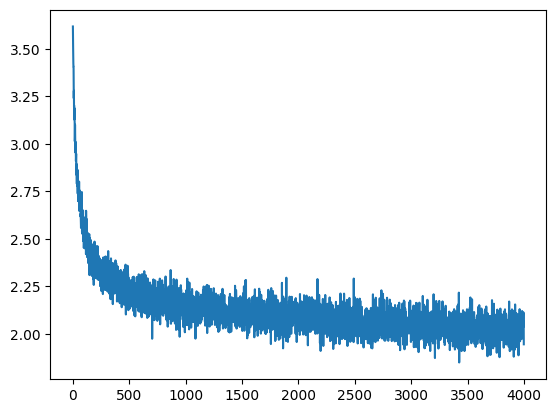

In [441]:
plt.plot(loss_history)

In [442]:
def sampling(model: NameGenModel, num_samples: int=10):
  model.eval()
  
  with torch.no_grad():
    # block = torch.full((1, block_size), 0).to(device=device, dtype=torch.long)

    for _ in range(num_samples):
      block = [0] * block_size
      output = []
      while True:
        scores = model(torch.tensor(block).view(1, -1).to(device=device))

        scores = F.softmax(scores, dim=1)

        ix = torch.multinomial(scores, num_samples=1).item()
        if ix_to_char[ix] == ".":
          break
        output.append(ix_to_char[ix])
        block = block[1:] + [ix]
      print("".join(output))



In [443]:
sampling(model, 10)

rasturish
chish
rita
raseshanshangvu
nrihesh
nira
murna
mana
nishab
mur
